In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import sys
import numpy as np


sys.path.append("../pauli_lindblad_per/")
from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [2]:
backend = FakeVigoV2()

In [3]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,10)]

In [4]:
def executor(circuits):
    return backend.run(circuits).result().get_counts()

In [5]:
experiment = tomography(circuits = circuits, inst_map = [0,1,2,3,4], backend = backend)

In [6]:
experiment.generate(samples = 32, single_samples = 200, depths = [2,4,8,16])

In [7]:
experiment.run(executor)

In [8]:
noisedataframe = experiment.analyze()

In [9]:
perexp = experiment.create_per_experiment(circuits)

In [10]:
import cProfile, pstats
from pstats import SortKey

In [11]:
expectations = ["ZIIII","IZIII","IIZII","IIIZI"]
perexp.generate(expectations = expectations, samples = 1000, noise_strengths = [0,.5,2])

## PER

In [12]:
perexp.run(executor)

In [13]:
circuit_results = perexp.analyze()

In [67]:
results = []
for run in circuit_results:
    tot = 0
    for op in expectations:
        expec = run.get_result(op).expectation
        tot += expec
    results.append(tot/4)

In [69]:
circuit_results[-1]._per_circ.overhead(0)

3.397389849754215

In [53]:
noisyresult = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= backend.run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    noisyresult.append(tot/(1024*n*2))

Text(0, 0.5, 'Z Magnetization')

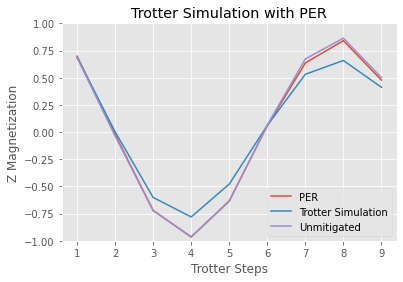

In [58]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.plot(range(1,10), results)
plt.plot(range(1,10), noisyresult)
plt.plot(range(1,10), res)
plt.ylim([-1,1])
plt.legend(["PER", "Trotter Simulation", "Unmitigated"])
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")

Text(0.5, 1.0, 'Expectation vs Noise Strength IIIZ')

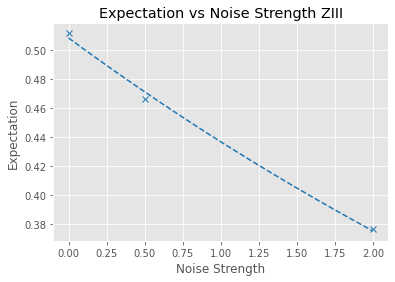

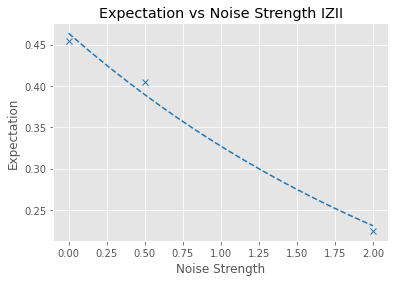

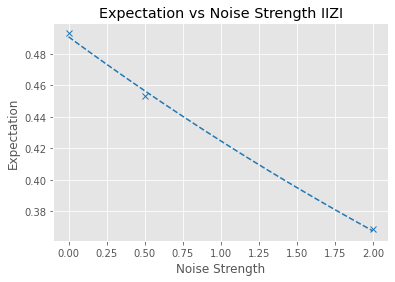

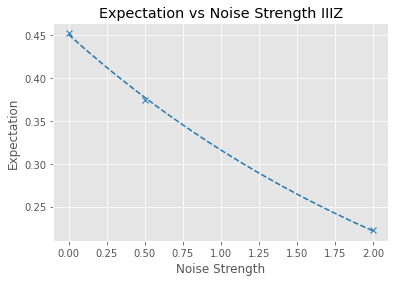

In [71]:
ax = circuit_results[-1].get_result("ZIIII").plot()
plt.title('Expectation vs Noise Strength ZIII')
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
circuit_results[-1].get_result("IZIII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IZII')
circuit_results[-1].get_result("IIZII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIZI')
circuit_results[-1].get_result("IIIZI").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIIZ')

## Analysis

In [16]:
layer1 = experiment.analysis.get_layer_data(0)

<AxesSubplot:>

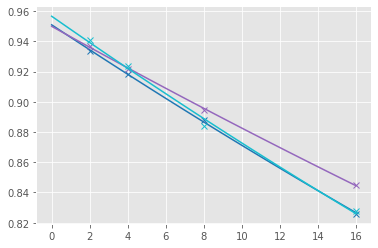

In [34]:
layer1.graph((1,))

<AxesSubplot:>

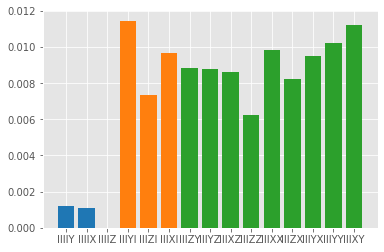

In [31]:
layer1.plot_infidelitites((0,),(1,),(0,1))

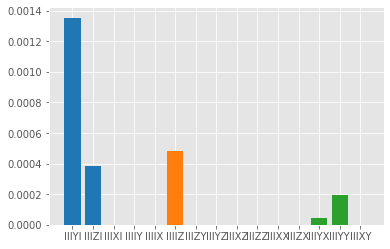

In [38]:
layer1.plot_coeffs((1,),(0,),(0,1))

In [54]:
import pickle
with open("graph.pickle", "wb") as f:
    pickle.dump(results, f)